In [1]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

In [3]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
sls.head()

,id,kdprov,kdkab,kdkec,kddesa,iddesa,idslsnon,nmslsnon,ketua_sls,jenis,...,j_bstt,j_bsbtt,j_bstt_k,j_bskeko,j_segmen,dom,ldom,j_m_all,j_m_30,klas_ur
0,263884,32,1,10,1,3201010001,100,RT 001 RW 001 DUSUN 1,MUHAMAD RAFLI HIDAYAT,1,...,39,1,2,4,1,1,1,51,51,2
1,263885,32,1,10,1,3201010001,200,RT 002 RW 001 DUSUN 1,NURMAN,1,...,60,2,0,7,1,1,1,62,61,2
2,263886,32,1,10,1,3201010001,300,RT 003 RW 001 DUSUN 1,SAENUDIN,1,...,50,2,0,6,1,1,1,58,57,2
3,263887,32,1,10,1,3201010001,400,RT 004 RW 001 DUSUN 1,AEP,1,...,27,1,0,1,1,1,1,31,31,2
4,263888,32,1,10,1,3201010001,500,RT 005 RW 001 DUSUN 1,JEJEN JAELANI,1,...,49,7,3,8,3,1,1,63,57,2


In [5]:
sls.iddesa.unique().shape

(5957,)

In [6]:
ur_path = "C:/Users/jwst2/Python/tesis/jpg/UR/14. Resolution compare sls sentinel"
gen_path =  "C:/Users/jwst2/Python/tesis/jpg/general sls sentinel 10m ES RES/"
test_path = 'C:/Users/jwst2/Python/tesis/jpg/UR/test sls sentinel ES RES/'
model_code_resnet = "R014"
model_code_dense = "D014"

In [7]:
os.chdir(ur_path)
if os.path.isdir('urban') is False:
    os.makedirs('urban')
    os.makedirs('rural')

In [8]:
yourpath = gen_path
from tqdm import tqdm

for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 1):
                shutil.copy(os.path.join(root, name), ur_path+"/urban/"+name)
            elif(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 2):
                shutil.copy(os.path.join(root, name),ur_path+ "/rural/"+name)
        except Exception:
            print(name)
            pass 

1it [14:02, 842.57s/it]


In [9]:
split = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/01 datasplit_ur_desa_uncovered.csv")

In [10]:
split.head()

,iddesa,klas_ur,stat
0,3207110010,1,train
1,3205200018,1,train
2,3210070011,1,train
3,3211010004,1,train
4,3201290007,1,train


In [11]:
split_test =split[split["stat"] == "test"]

In [12]:
split_test

,iddesa,klas_ur,stat
4840,3213080006,2,test
4841,3212081006,2,test
4842,3276050006,1,test
4843,3203010002,2,test
4844,3208161002,1,test
...,...,...,...
5373,3276040009,1,test
5374,3214070007,1,test
5375,3209120023,1,test
5376,3202280008,1,test


### Create test

In [13]:
os.chdir(test_path)
if os.path.isdir('urban') is False:
    os.makedirs('urban')
    os.makedirs('rural')

In [14]:
yourpath = ur_path+ "/rural"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                shutil.move(os.path.join(root, name),test_path + "/rural/"+name)
        except Exception:
            print(name)
            pass 

1it [00:26, 26.09s/it]


In [15]:
yourpath =  ur_path+ "/urban"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                shutil.move(os.path.join(root, name), test_path +"/urban/"+name)
        except Exception:
            print(name)
            pass 

1it [01:56, 116.82s/it]


### Run Dataset

In [16]:
path = Path.cwd() / (ur_path)

In [17]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('rural'),Path('urban')]

In [18]:
fname = (path/"rural").ls()[0]
fname

Path('rural/32010100010001.jpg')

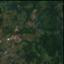

In [19]:
img = Image.open(fname)
img

In [27]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label # extracts the label category from the image's folder name 
                 ,item_tfms = Resize(32)) # data augmentation (mult multiplies the default transformation values)

In [28]:
dls = blocks.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


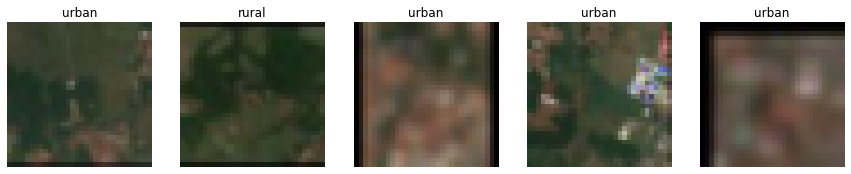

In [29]:
dls.show_batch(nrows=1, ncols=5)

In [30]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

In [31]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.359564,0.350966,0.836364,0.682424,0.749647,0.682424,0.705507,0.862055,17:10
1,0.350219,0.338628,0.840268,0.666731,0.768292,0.666731,0.695364,0.871207,09:18
2,0.328720,0.337613,0.841495,0.669078,0.771120,0.669078,0.698059,0.872382,09:16


In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.355841,0.403191,0.823090,0.586654,0.764666,0.586654,0.601223,0.831955,11:01
1,0.352843,0.405254,0.803235,0.508701,0.745089,0.508701,0.464288,0.860011,10:23
2,0.353911,0.404033,0.837033,0.680523,0.752008,0.680523,0.704492,0.866708,10:27
3,0.351192,0.349453,0.835527,0.635419,0.774007,0.635419,0.663552,0.866044,10:20
4,0.343973,0.337634,0.838483,0.699557,0.750566,0.699557,0.719063,0.872615,10:15
5,0.344806,0.338043,0.838706,0.651211,0.773542,0.651211,0.680649,0.875716,10:40
6,0.345386,0.334925,0.840268,0.716377,0.751488,0.716377,0.731112,0.877026,10:31
7,0.320751,0.329240,0.842722,0.694298,0.762595,0.694298,0.718305,0.879127,10:52
8,0.322767,0.328979,0.842889,0.694929,0.762816,0.694929,0.718865,0.879326,10:35
9,0.312239,0.329960,0.842108,0.690858,0.762199,0.690858,0.715426,0.878785,10:53


In [34]:
dls.vocab

['rural', 'urban']

In [35]:
dls.train.items[175000]

IndexError: list index out of range

In [36]:
learn.export("C:/Users/jwst2/Python/tesis/models/19042022"+ model_code_dense+".pkl")

### Up level

In [37]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [38]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [39]:
pd.value_counts(true_label)

1    129790
0     31584
dtype: int64

In [40]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,2.667928e-01,0.733207,32071200060007,1.0,3207120006
1,4.172266e-03,0.995828,32731010030083,1.0,3273101003
2,3.959764e-07,1.000000,32770300020058,1.0,3277030002
3,1.585651e-03,0.998414,32171300060016,1.0,3217130006
4,2.529079e-02,0.974709,32100700070016,1.0,3210070007


In [41]:
pd.value_counts(df.stat)

1.0    140037
0.0     21337
Name: stat, dtype: int64

In [42]:
df["true_lab"] = true_label

In [43]:
pd.value_counts(df.true_lab)

1    129790
0     31584
Name: true_lab, dtype: int64

In [44]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.8548898831286329

In [45]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,2.667928e-01,0.733207,32071200060007,1.0,3207120006,1
1,4.172266e-03,0.995828,32731010030083,1.0,3273101003,1
2,3.959764e-07,1.000000,32770300020058,1.0,3277030002,1
3,1.585651e-03,0.998414,32171300060016,1.0,3217130006,1
4,2.529079e-02,0.974709,32100700070016,1.0,3210070007,1


In [46]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [47]:
desa_pred.columns = ["pred","true"]

In [48]:
pd.value_counts(df.stat)

1.0    140037
0.0     21337
Name: stat, dtype: int64

In [49]:
for i in np.arange(0.1, 0.95, 0.025):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred["label"+str(value)][desa_pred.pred > value] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_25312/935834860.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred["label"+str(value)][desa_pred.pred > value] = 1


In [50]:
desa_pred.head()

,pred,true,label0.1,label0.12,label0.15,label0.18,label0.2,label0.22,label0.25,label0.27,...,label0.7,label0.72,label0.75,label0.77,label0.8,label0.82,label0.85,label0.87,label0.9,label0.92
iddesa,,,,,,,,,,,,,,,,,,,,,
3201010001,0.075472,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3201010003,0.900000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
3201010004,0.804348,0.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
3201010005,0.900000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
3201010006,0.827586,0.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0


In [51]:
for j in range(2,36):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.7704545454545455
precision : 0.7650460484043693
result label0.12
accuracy : 0.7725206611570248
precision : 0.7669172932330827
result label0.15
accuracy : 0.778305785123967
precision : 0.7721464154212693
result label0.18
accuracy : 0.7845041322314049
precision : 0.77755948482864
result label0.2
accuracy : 0.7884297520661157
precision : 0.7810443176831944
result label0.22
accuracy : 0.7898760330578513
precision : 0.7823697515937569
result label0.25
accuracy : 0.797107438016529
precision : 0.7888198757763976
result label0.27
accuracy : 0.7991735537190082
precision : 0.790702846975089
result label0.3
accuracy : 0.8033057851239669
precision : 0.795822102425876
result label0.32
accuracy : 0.8072314049586777
precision : 0.799774011299435
result label0.35
accuracy : 0.8134297520661157
precision : 0.8064884624171808
result label0.37
accuracy : 0.8175619834710743
precision : 0.8107610945044837
result label0.4
accuracy : 0.8214876033057851
precision : 0.81563079777365

In [52]:
pd.value_counts(desa_pred.true)

1.0    3586
0.0    1254
Name: true, dtype: int64

### Test result

In [53]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [54]:
len(test_files)

20896

In [55]:
test_dl = learn.dls.test_dl(test_files)

In [56]:
preds,_ = learn.get_preds(dl  =test_dl)

In [57]:
str(test_files[1])[-18:-4]

'32010100020002'

In [58]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("urban" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [59]:
test = pd.DataFrame(preds)

In [60]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [61]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [62]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.447116,0.552884,32010100020001,0,3201010002,1.0
1,0.251953,0.748047,32010100020002,0,3201010002,1.0
2,0.135553,0.864447,32010100020003,0,3201010002,1.0
3,0.173367,0.826633,32010100020004,0,3201010002,1.0
4,0.362141,0.637859,32010100020005,0,3201010002,1.0


In [63]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [64]:
desa_pred_test

,stat,true_lab
,mean,mean
iddesa,,
3201010002,0.666667,0.0
3201020016,0.974359,1.0
3201021008,0.777778,1.0
3201030012,1.000000,1.0
3201040007,1.000000,1.0
...,...,...
3278031006,0.961538,1.0
3279010001,0.931035,1.0


In [65]:
desa_pred_test.columns = ["pred","true"]

In [78]:
desa_pred_test["pred_lab"] = 0
desa_pred_test["pred_lab"][desa_pred_test.pred > 0.8] = 1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_25312/3417576388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa_pred_test["pred_lab"][desa_pred_test.pred > 0.8] = 1


In [79]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.8271375464684015
balanced_accuracy_score : 0.7766690595836324
precision : 0.8841309823677582
recall : 0.8819095477386935
f1 : 0.8830188679245283
rocauc : 0.7766690595836325
